### Plotting whole-community abundance and eukaryotic community abundance from metatranscriptomic analysis

In [1]:
import glob
import os
import pandas as pd
import pysam
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
working_dir = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/data/' \
            'metaT_trimmed_reads/fasta_files/paired/mRNA/whole_community_transcripts/'

In [3]:
# Categories listed in Cohen et al. (2021)

wc_categories = ['Bacteroidetes', 'Alphaproteobacteria', 'Betaproteobacteria', 'Deltaproteobacteria', 
                 'Gammaproteobacteria', 'Other proteobacteria', 'Other bacteria', 'Archaea', 'Prochlorococcus', 
                 'Synechococcus', 'Other cyanobacteria', 'Chlorophyta', 'Cryptophyta', 'Diatom', 
                 'Other stramenopiles', 'Dinophyta', 'Haptophyta', 'Amoebozoa', 'Ciliophora', 'Excavata', 'Fungi', 
                 'Metazoa', 'Other eukaryotes', 'Rhizaria', 'Viruses']

In [4]:
# Get a list of all the individual TSVs we made with Reclassify_transcripts_for_relative_abundance.ipynb

taxonomy_files = glob.glob(working_dir + '*')

#### Interpreting relative community abundance as the fraction of original reads that mapped to a given phylum, super group, etc. relative to the total number of reads. 
In the paper, they use a combination of phylum, supergroup, genus and other taxonomic classifications, depending on what's present and interesting, so we have used the exact same breakdown, as opposed to a straight phylum-only breakdown or other approach.

To do this, we want to use the output of the BWA alignment to get the number of reads that correspond to an individual contig, then sum at the individual levels to get a total number of reads for each classification. Using a similar approach to `TPM_normalization_and_plotting.ipynb`, but we are not normalizing by gene length because we're not looking at individual gene expression.

In [5]:
### Already have taxon_df generated from before

In [6]:
#Paths to the BWA alignment output

bam_paths = ['../bwa_mem_nucleotide_files/30B8Z_S11_001_40m_mRNA_mapped_sorted.bam',
            '../bwa_mem_nucleotide_files/30B90_S12_001_70m_mRNA_mapped_sorted.bam',
            '../bwa_mem_nucleotide_files/30B91_S28_001_380m_mRNA_mapped_sorted.bam']

In [7]:
def join_read_counts(df_taxon, bam_path):
    # This function takes in the location of bam files and a dataframe with contig and taxonomy info
    # and returns the same dataframe with read counts added
    samfile = pysam.AlignmentFile(working_dir+path, "rb")
    sample_id = path.split('/')[1].split('_mRNA')[0]

    # "Index statistics" are the names of the contigs and how many reads mapped to each one
    idx_stats = samfile.get_index_statistics()

    # convert into a more generic output, i.e. a list
    contigs = []
    mapped = []
    unmapped = []

    # add contig names to a contigs list, number of mapped reads to a mapped list, 
    # number of unmapped reads to an unmapped list
    for contig_stat in idx_stats:
        contigs.append(contig_stat.contig)
        mapped.append(contig_stat.mapped)
        unmapped.append(contig_stat.unmapped)

    #Convert lists to a dataframe
    ORF_read_counts = pd.DataFrame({'contig': contigs, 'mapped': mapped, 'unmapped': unmapped})

    #Ignore all contigs with no mapping hits
    ORF_read_counts = ORF_read_counts[ORF_read_counts['mapped'] != 0]

    #Inner join on the input ORF taxonomy df to just get the intersection of the two 
    taxon_ORF_reads = ORF_read_counts.join(df_taxon.set_index('qseqid'), on='contig', how='inner')

    return taxon_ORF_reads

In [8]:
# Loop through each sample, so that output is a dictionary of dictionaries, where each sample is a key
# and the dictionary for each sample has keys that correspond to the names of taxa and the values are the number
# of total reads for that taxa

abundance_dict = {}

for path in bam_paths:
    
    #Use regex to get the name of the site
    sample_name = re.search('[0-9]{2,3}m', path)[0]
    print(sample_name)
    
    sample_abundance_dict = {}

    for file in taxonomy_files:
        #Get just the name of the classification, which is the very end of the file i.e. .../transcripts_Rhizaria.tsv
        name = re.search('transcripts_.*.tsv', file)[0].split('transcripts_')[1].split('.tsv')[0]
        print(name)
        #Read in data
        taxon_df = pd.read_csv(file, sep='\t')
        #Link BWA mapping of original reads with each ORF
        temp_df = join_read_counts(taxon_df, path)
        #Calculate "abundance" as the sum of total reads mapped to the group
        abundance = temp_df['mapped'].sum()
        #Add to a dictionary
        sample_abundance_dict[name] = abundance
    
    #Add dictionary of taxa + abundance as an entry in the full dictionary with sample ID as key
    abundance_dict[sample_name] = sample_abundance_dict
    

40m
Other_cyanobacteria
Rhizaria
Betaproteobacteria
Fungi
Amoebozoa
Other_stramenopiles
Deltaproteobacteria
Archaea
Viruses
Alphaproteobacteria
Other_proteobacteria
Bacteroidetes
Dinophyta
Other_eukaryotes
Haptophyta
Prochlorococcus
Cryptophyta
Gammaproteobacteria
Excavata
Metazoa
Other_bacteria
Ciliophora
Chlorophyta
Diatom
Synechococcus
70m
Other_cyanobacteria
Rhizaria
Betaproteobacteria
Fungi
Amoebozoa
Other_stramenopiles
Deltaproteobacteria
Archaea
Viruses
Alphaproteobacteria
Other_proteobacteria
Bacteroidetes
Dinophyta
Other_eukaryotes
Haptophyta
Prochlorococcus
Cryptophyta
Gammaproteobacteria
Excavata
Metazoa
Other_bacteria
Ciliophora
Chlorophyta
Diatom
Synechococcus
380m
Other_cyanobacteria
Rhizaria
Betaproteobacteria
Fungi
Amoebozoa
Other_stramenopiles
Deltaproteobacteria
Archaea
Viruses
Alphaproteobacteria
Other_proteobacteria
Bacteroidetes
Dinophyta
Other_eukaryotes
Haptophyta
Prochlorococcus
Cryptophyta
Gammaproteobacteria
Excavata
Metazoa
Other_bacteria
Ciliophora
Chlorophy

In [75]:
#Convert dictionary to dataframe 
abundance_df = pd.DataFrame(abundance_dict)

#Sorting it so that shallowest sample will plot on top for a horizontal bar chart
abundance_df = abundance_df[['380m', '70m', '40m']]

In [76]:
#Clean up dataframe, i.e. remove underscores and reorder to match the original plot

abundance_df.index = abundance_df.index.str.replace('_', ' ')
abundance_df = abundance_df.loc[wc_categories] #sort similar to original plot

In [77]:
#Calculate relative abundance from total counts
rel_abundance_df = abundance_df*100/abundance_df.sum()
#Add prefix to identify it as station 9
rel_abundance_df = rel_abundance_df.add_prefix('9_')
rel_abundance_df.index = rel_abundance_df.index.str.capitalize()

In [78]:
#Get number of rows
df_len = rel_abundance_df.shape[0]

In [79]:
custom_palette = sns.color_palette("tab20b", df_len).as_hex()

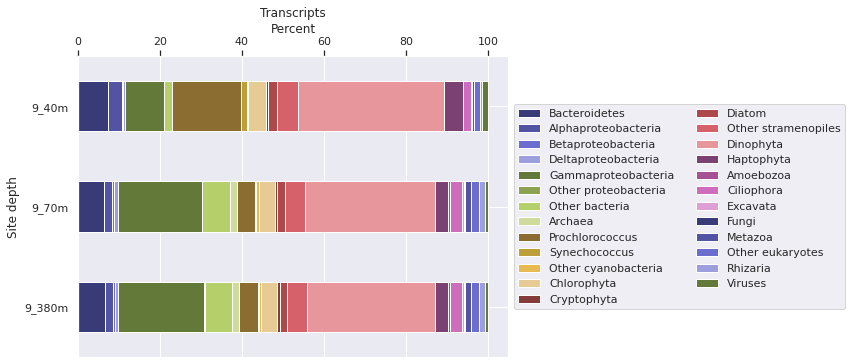

In [81]:
sns.set()

#Plotting horizontal bar chart with custom palette
fig, ax = plt.subplots(figsize = (12, 5))
rel_abundance_df.transpose().plot.barh(stacked='True', ax=ax, color=custom_palette)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.ylabel('Site depth')
plt.xlabel('Percent')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

plt.tight_layout()
plt.title('Transcripts')

plt.savefig('/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/output/' \
            'transcripts_whole_community_abundance_plot.png', dpi=300, bbox_inches='tight')

### Filtering for eukaryotes only (Fig. 1b)

In [85]:
colors = ['#B2DF8A', '#CAB2D6', '#FDBF6F', '#FFFF99', '#1F78B4', '#FF0000', '#E7298A', 
         '#1B9E77', '#D95F02', "#7570B3", '#E6AB02', '#66A61E', '#ADD8E6']

#Trying to use similar colors to similar plot made from 18S data

In [86]:
# List of eukaryotic taxa of interest comes from Cohen et al. paper
euks = ['Rhizaria', 'Fungi', 'Amoebozoa', 'Other stramenopiles', 'Diatom', 'Other eukaryotes', 'Dinophyta',
        'Haptophyta', 'Excavata', 'Metazoa', 'Ciliophora', 'Cryptophyta', 'Chlorophyta']
euks.sort() #sort alphabetically

In [87]:
#Calculate relative abundance from total counts
euk_abundance_df = abundance_df.loc[euks]
rel_abundance_df = euk_abundance_df*100/euk_abundance_df.sum()
#Add prefix to identify it as station 9
rel_abundance_df = rel_abundance_df.add_prefix('9_')
rel_abundance_df.index = rel_abundance_df.index.str.capitalize()

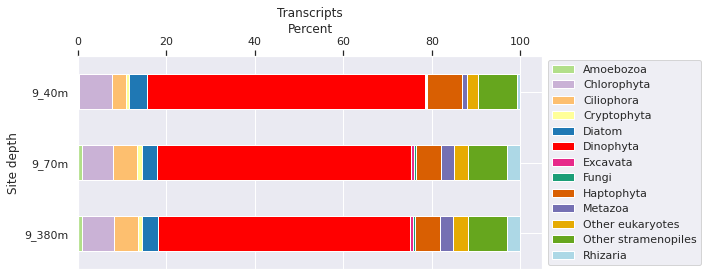

In [73]:

#Plotting horizontal bar chart with custom palette
fig, ax = plt.subplots(figsize = (10, 4))
rel_abundance_df.transpose().plot.barh(stacked='True', ax=ax, color=colors)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('Site depth')
plt.xlabel('Percent')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

plt.title('Transcripts')
plt.tight_layout()

plt.savefig('/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/output/' \
            'transcripts_eukaryotic_community_abundance_plot.png', dpi=300)

![](images/eukaryotic_abundance_transcripts)

![](images/eukaryotic_abundance_transcripts)

In [97]:
dino_read_average = rel_abundance_df.loc['Dinophyta'].mean()
dino_read_std = rel_abundance_df.loc['Dinophyta'].std()

print(f"Dinoflagellates comprise {dino_read_average} ± {dino_read_std}% of transcriptomic read count")

Dinoflagellates comprise 59.118838933563886 ± 3.208045125667704% of transcriptomic read count
